In [266]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [267]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Opening data file

In [268]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

print (type(mat_contents))
mat_contents.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'dataset', 'labels'])

Separating parameters and labels

In [269]:
print ('dataset: ',mat_contents['dataset'].shape)
print ('labels: ',mat_contents['labels'].shape)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases, experiments

y = mat_contents['labels'].reshape(Nc)
print ('y: ',len(y))
y[::50]

dataset:  (8192, 5, 850)
labels:  (1, 850)
y:  850


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

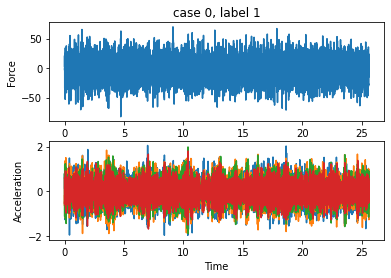

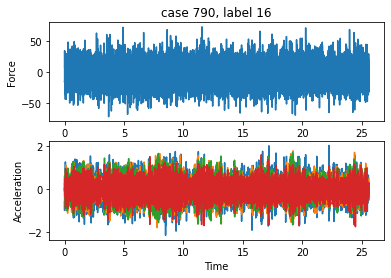

In [270]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.subplots()
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

Transposing the channel dat: Ch(i) > X(i), i in {2,3,4,5}

In [271]:
x2 = Ch2.transpose()
x3 = Ch3.transpose()
x4 = Ch4.transpose()
x5 = Ch5.transpose()

Fitting AR model and building X1 matrix

In [272]:
modelOrder = 30

x2r = []
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

PCA analysis

Text(0, 0.5, 'Cumulative Explained Variance [%]')

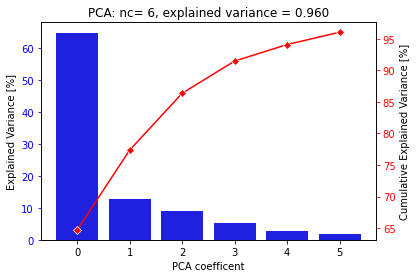

In [273]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b')
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D')
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')

Building x2 by transforming the x1 data with the previous PCA model
Creating a pandas dataframe associated with x2

In [274]:
X2 = pca.fit_transform(X1)

Scaling features form both X1 and X2

In [275]:
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

print ("not scaled: ", X2[0], "\nscaled: ", X2_scaled[0])

not scaled:  [ 7.66136505 -1.41780663  0.80665171  0.89625556 -1.19463583 -0.13840328] 
scaled:  [ 0.75017416 -0.61278049  0.16699462 -0.2637636  -0.44727164 -0.14540835]


Creating pandas dataframe versions of the scaled x1, x1+label, x2 and x2+label

In [276]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1_label = dfx1.copy()
dfx1_label['label'] = y

dfx2 = pd.DataFrame(X2_scaled)
dfx2_label = dfx2.copy()
dfx2_label['label'] = y

dfx2_label.sample(10)

,0,1,2,3,4,5,label
72,0.492730,-0.510456,0.092246,-0.519056,0.292897,-0.335481,2
178,0.340733,-0.141900,0.178430,-0.937845,0.397044,-0.198246,4
593,-0.876927,-0.146072,0.617580,-0.168229,-0.046780,-0.553496,12
429,-0.443589,0.400015,-0.297074,-0.452855,-0.310380,-0.905065,9
502,-0.818010,-0.604221,0.005637,-0.412033,0.091594,-0.061433,11
121,0.860922,-0.667968,0.236884,-0.712540,0.356064,0.132899,3
715,-0.604481,-0.377800,-0.420443,-0.267999,0.276898,-0.258178,15
275,0.408999,-0.643602,-0.444085,-0.535898,-1.000000,0.419447,6
817,-0.934844,-0.499960,0.528873,-0.261535,0.150835,0.222283,17
550,-0.864537,-0.637157,0.107870,-0.367822,0.047620,0.045850,12


AR x PCA heatmap

Text(609.9818181818181, 0.5, 'experiment')

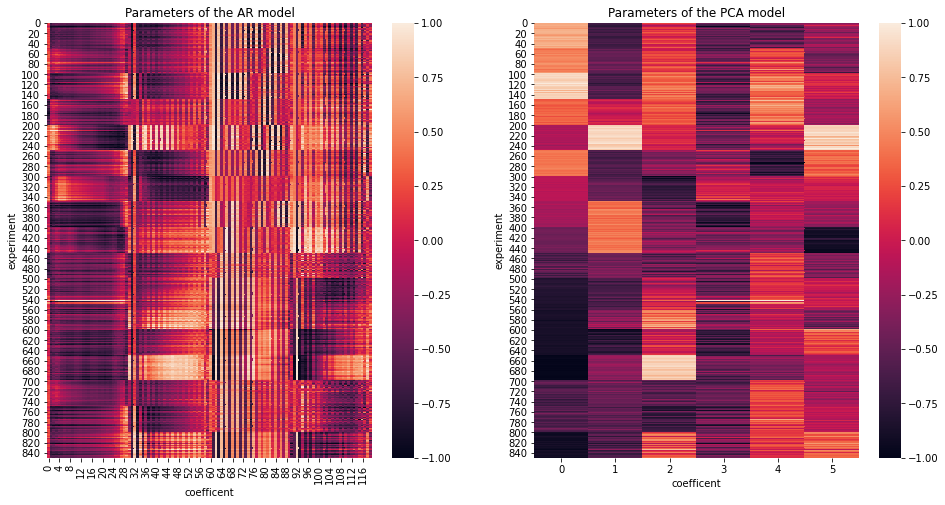

In [277]:
plt.subplots(figsize=(16,8))
plt.subplot(121)
ax = sns.heatmap(dfx1)
ax.set_title('Parameters of the AR model')
ax.set_xlabel('coefficent')
ax.set_ylabel('experiment')
plt.subplot(122)
ax2 = sns.heatmap(dfx2)
ax2.set_title('Parameters of the PCA model')
ax2.set_xlabel('coefficent')
ax2.set_ylabel('experiment')


Crossplot of the first three features of the PCA analysis

Text(0.5, 0.98, 'PCA Components Pairwise Plots')

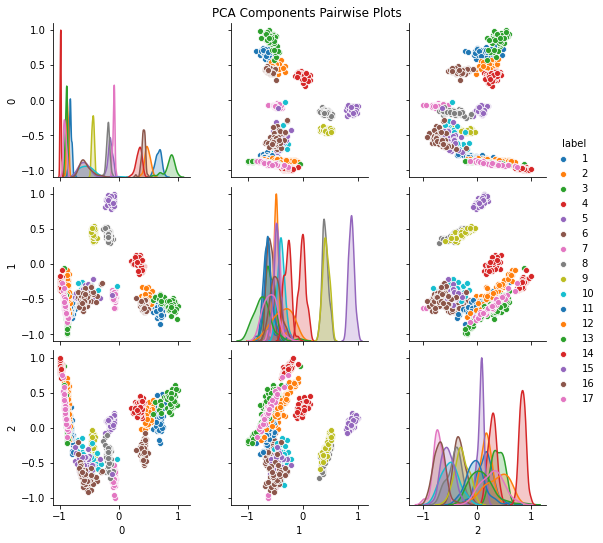

In [278]:
pp = sns.pairplot(data=dfx2_label.iloc[:,[0,1,2,-1]], hue='label', palette='tab10')
pp.fig.subplots_adjust(top=0.95, wspace=0.3)
pp.fig.suptitle('PCA Components Pairwise Plots')

Plotting Multidimenssional Spaces

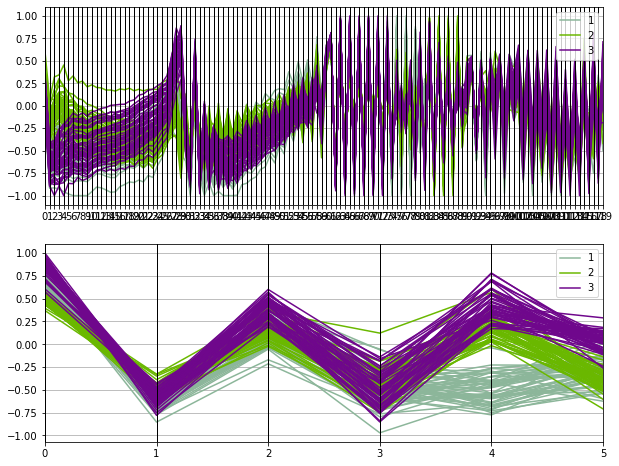

In [279]:
plt.figure(figsize=(10,8))
plt.subplot(211)
# pd.plotting.parallel_coordinates(dfx1_label, 'label')
pd.plotting.parallel_coordinates(dfx1_label[dfx1_label['label']<=3], 'label')
plt.subplot(212)
# pd.plotting.parallel_coordinates(dfx2_label, 'label')
pd.plotting.parallel_coordinates(dfx2_label[dfx2_label['label']<=3], 'label')

#### Note:
Testing some values for the classes the comparison above suggests that the classes would be easier to classificate using the X2 features

Preparing data by separating train and test 

In [280]:
# From now on we dont use the '_scaled' for the test and train ensemples anymore

test_size = 0.15
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=test_size, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=test_size, random_state=10)

print ('# Train X1:', X1_train.shape[0])
print ('# Test X1:', X1_test.shape[0])
print ('# Train y:', len(y_train))
print ('# Test y:', len(y_test))

# Check if the y split is the same
print ('This must be zero: ', sum(y2_train-y_train))
print ('This must also be zero: ', sum(y2_test-y_test))

# Train X1: 722
# Test X1: 128
# Train y: 722
# Test y: 128
This must be zero:  0
This must also be zero:  0


Softmax Linear Model (logistic regression with multiple classes)

In [281]:
model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200).fit(X1_train, y_train)
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200).fit(X2_train, y_train)

yPred1_train = model1.predict(X1_train)
yPred1_test = model1.predict(X1_test)

yPred2_train = model2.predict(X2_train)
yPred2_test = model2.predict(X2_test)

print ("Autoreg accuracy:")
print ("Train: ", accuracy_score(y_train, yPred1_train))
print ("Test: ", accuracy_score(y_test, yPred1_test))

print ("\nPCA accuracy:")
print ("Train: ", accuracy_score(y_train, yPred2_train))
print ("Test: ", accuracy_score(y_test, yPred2_test))

Autoreg accuracy:
Train:  0.9986149584487535
Test:  1.0

PCA accuracy:
Train:  0.9030470914127424
Test:  0.8828125
